# Set Up

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets, plotting
import random
import re

In [12]:
random.seed(42)
np.random.seed(42)

In [13]:
def plot_pls_weights(weights_filepath, data_name, target_name, top_n=50):
    # Load PLS weights
    weights_df = pd.read_csv(weights_filepath, index_col=0)
    W = weights_df.values
    all_feature_names = weights_df.index.tolist()

    print(f"Loaded PLS weights from: {weights_filepath}")
    print(f"Shape: {W.shape}")
    print(f"Components: {weights_df.columns.tolist()}")
    
    # Load MIND regions
    with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
        MIND_regions = [line.strip() for line in f.readlines()]

    # Create edge lists for each component (up to 3 components)
    n_components = min(W.shape[1], 3)
    edge_lists = []
    
    for comp in range(n_components):
        edge_list = []
        for i, feature_name in enumerate(all_feature_names):
            if feature_name in MIND_regions:
                regions = feature_name.split('-')
                if len(regions) == 2:
                    region1, region2 = regions
                    edge_list.append((region1, region2, W[i, comp]))
        edge_lists.append(edge_list)

    # FreeSurfer centroids parsing function
    def parse_freesurfer_centroids(centroids_path):
        region_to_coord = {}
        with open(centroids_path, 'r') as f:
            for line in f:
                if line.startswith('#') or line.strip() == "":
                    continue
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                label = parts[1]
                coords = tuple(map(float, parts[2:5]))
                # Convert 'ctx-lh-bankssts' -> 'lh_bankssts'
                match = re.match(r'ctx-(lh|rh)-(.*)', label)
                if match:
                    hemi, region = match.groups()
                    key = f"{hemi}_{region}"
                    region_to_coord[key] = coords
        return region_to_coord

    centroids_file = '/Users/baileyng/MIND_models/centroids.txt'
    region_to_coord = parse_freesurfer_centroids(centroids_file)
    
    component_names = ['PLS1', 'PLS2', 'PLS3'][:n_components]

    for comp_idx, (edge_list, comp_name) in enumerate(zip(edge_lists, component_names)):
        # Sort edges by magnitude and take top edges
        edge_list_sorted = sorted(edge_list, key=lambda x: abs(x[2]), reverse=True)
        top_edges = edge_list_sorted[:top_n]
        
        # Getting list of nodes and coordinates  
        node_labels = sorted({n for edge in top_edges for n in edge[:2]})
        coords_native = []
        missing = []
        for label in node_labels:
            if label in region_to_coord:
                coords_native.append(region_to_coord[label])
            else:
                coords_native.append((float('nan'), float('nan'), float('nan')))
                missing.append(label)
        coords_native = np.array(coords_native)
        label_to_idx = {lab: i for i, lab in enumerate(node_labels)}
        n_nodes = len(node_labels)

        if missing:
            print(f"WARNING: The following regions were not found in centroids.txt for {comp_name}:")
            print(missing)

        # Transform coordinates to MNI space  
        def load_talairach_xfm(xfm_path):
            with open(xfm_path) as f:
                lines = f.readlines()
            start = [i for i, l in enumerate(lines) if 'Linear_Transform' in l][0]
            matrix_lines = lines[start+1:start+4]
            matrix = np.array([
                [float(val.strip(';')) for val in line.strip().split()]
                for line in matrix_lines
            ])
            affine = np.eye(4)
            affine[:3, :4] = matrix
            return affine

        talairach_xfm = '/Applications/freesurfer/subjects/bert/mri/transforms/talairach.xfm'
        affine = load_talairach_xfm(talairach_xfm)
        coords_mni = nib.affines.apply_affine(affine, coords_native)

        # Create adjacency matrix
        adj_matrix = np.zeros((n_nodes, n_nodes))
        for n1, n2, w in top_edges:
            i, j = label_to_idx[n1], label_to_idx[n2]
            adj_matrix[i, j] = w
            adj_matrix[j, i] = w  # For undirected connectome

        # Scale coordinates
        def scale_coords_to_brain(coords, scale=1.0):
            mean = np.mean(coords, axis=0)
            coords_centered = coords - mean
            coords_scaled = coords_centered * scale
            coords_scaled = coords_scaled + mean
            return coords_scaled

        coords_mni_scaled = scale_coords_to_brain(coords_mni, scale=1.0)

        # Calculate symmetric limits for colorbar
        max_abs_val = np.max(np.abs(adj_matrix))
        
        print(f"{comp_name}: Top edge weight magnitude: {max_abs_val:.4f}")

        # Plot  
        fig = plt.figure(figsize=(12, 8))

        display = plotting.plot_connectome(
            adj_matrix,
            coords_mni_scaled,
            edge_threshold=0.0,
            node_color='black',
            node_size=50,
            display_mode='ortho',
            title=f"Top {top_n} Edges - {comp_name} ({data_name} vs {target_name})",
            figure=fig,
            edge_cmap='bwr',
            edge_vmin=-max_abs_val,
            edge_vmax=max_abs_val,
            node_kwargs={'alpha': 0.9}
        )

        sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-max_abs_val, vmax=max_abs_val))
        sm.set_array([])
        cbar_ax = fig.add_axes([0.35, 0.15, 0.3, 0.03])  # [left, bottom, width, height]
        cb = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cb.set_label('Edge Weight (Red = Positive, Blue = Negative)', fontsize=14, labelpad=10)
        cb.ax.tick_params(labelsize=12)

        plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar
        plt.show()

# Python

Loaded PLS weights from: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_MIND_GF.csv
Shape: (2282, 6)
Components: ['Component_1', 'Component_2', 'Component_3', 'Component_4', 'Component_5', 'Component_6']
PLS1: Top edge weight magnitude: 0.0555


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_82552/3703322127.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


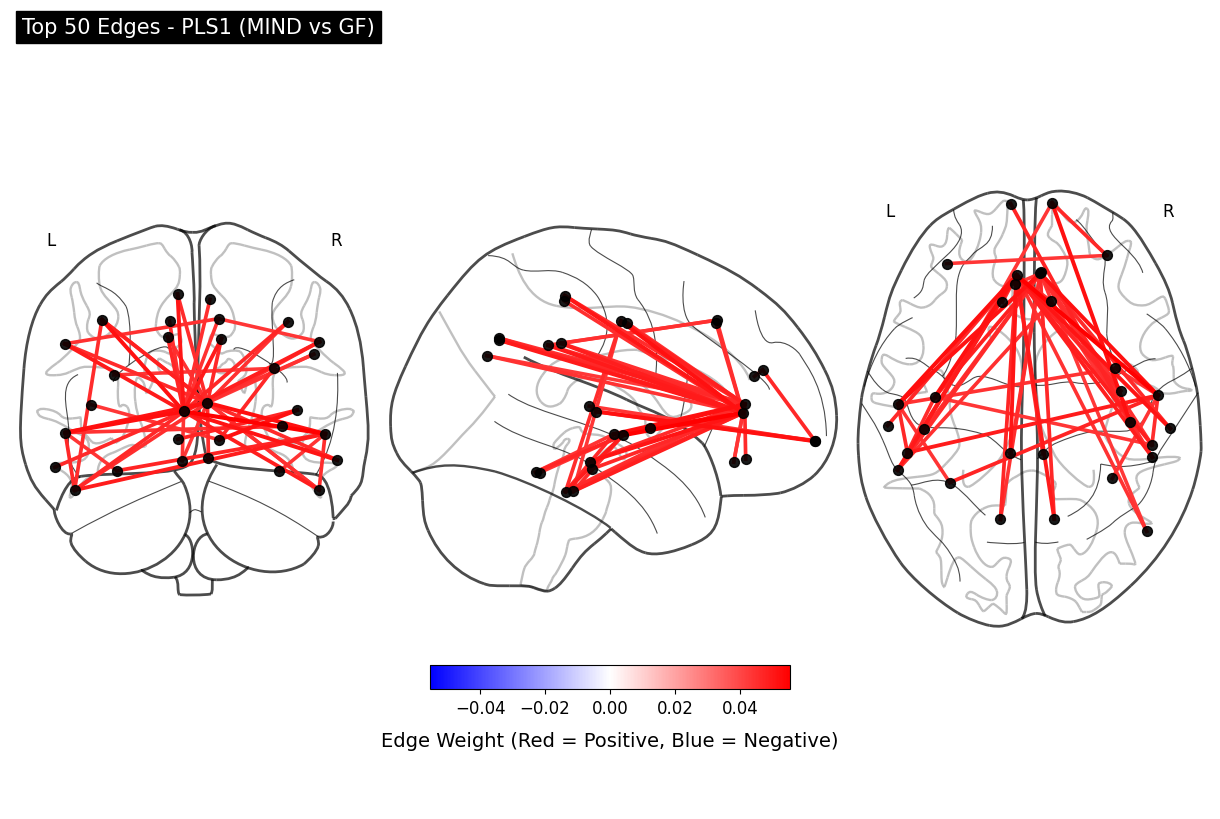

PLS2: Top edge weight magnitude: 0.0704


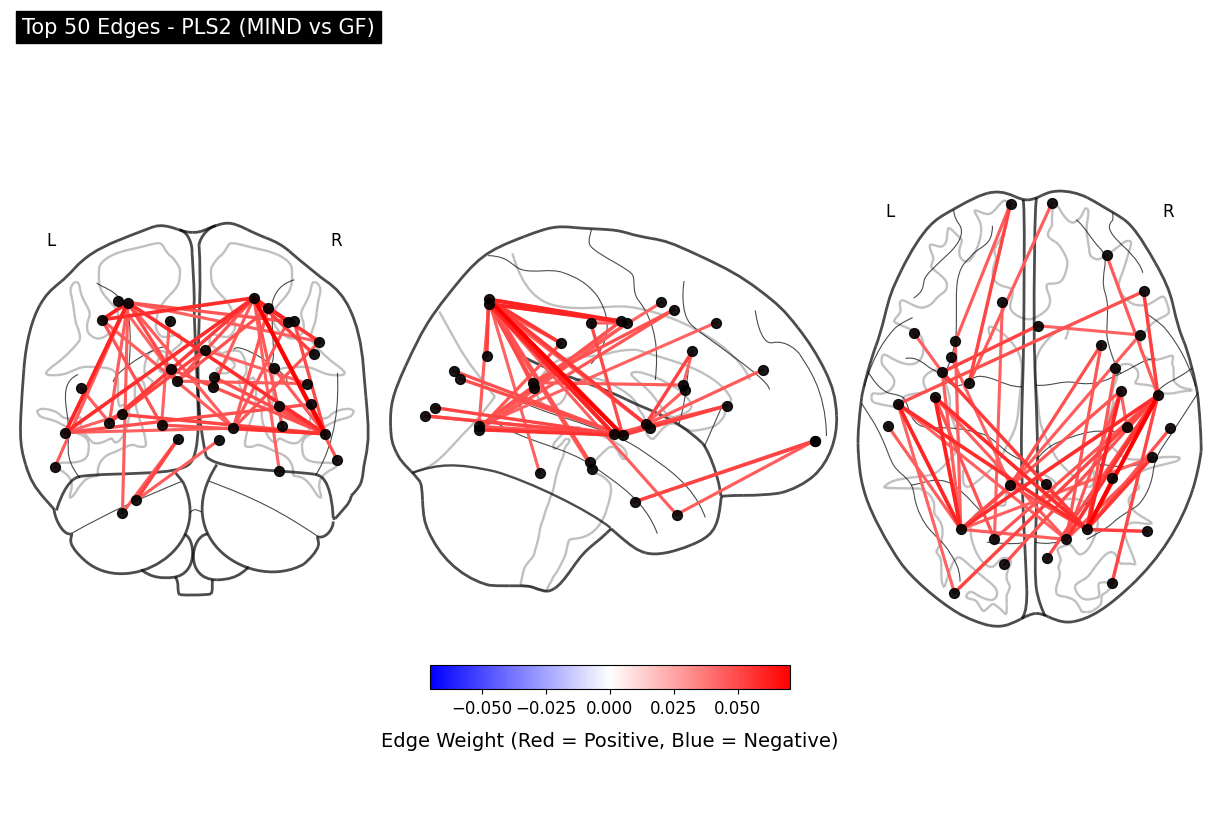

PLS3: Top edge weight magnitude: 0.0717


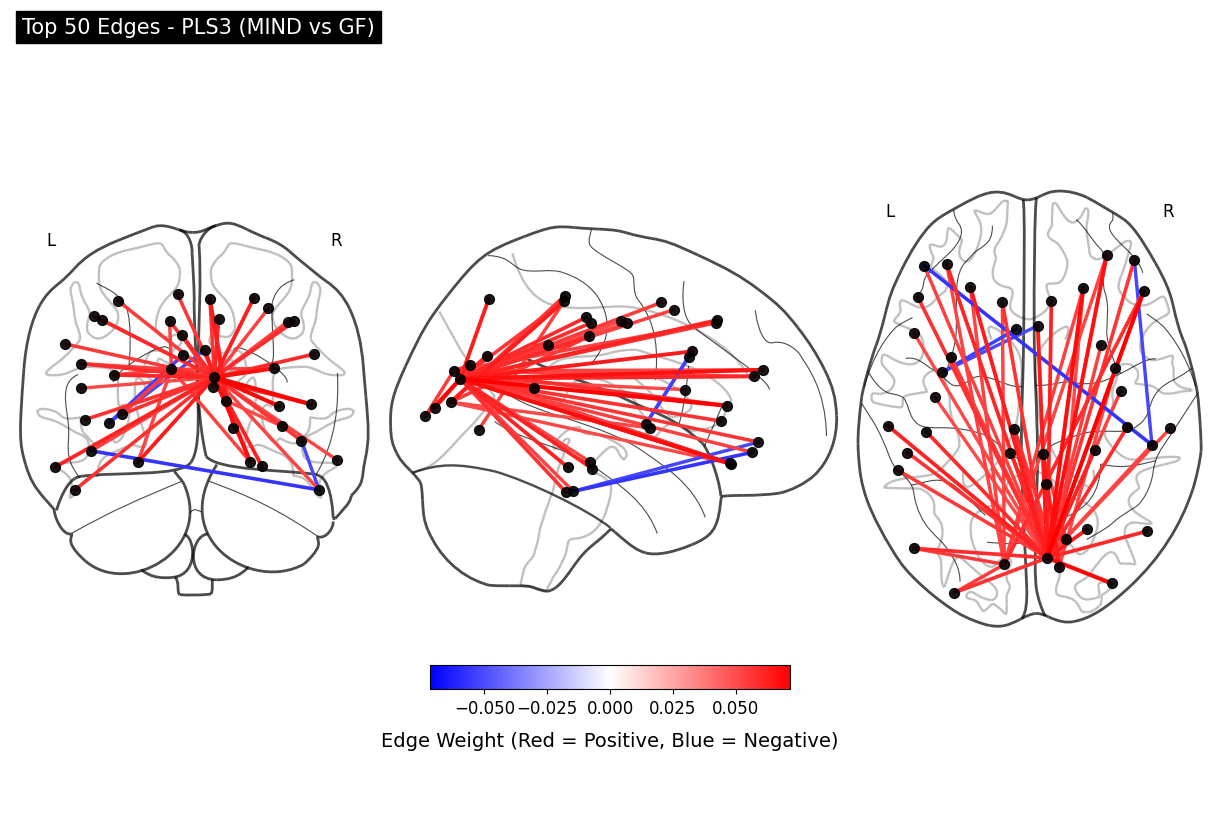

In [14]:
weights_file = '/Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_MIND_GF.csv'
plot_pls_weights(weights_file, 'MIND', 'GF', top_n=50)

# Python reg

Loaded PLS weights from: /Users/baileyng/MIND_models/models_plsregression/PLS_weights_reg/PLS_weights_MIND_GF5.csv
Shape: (2278, 5)
Components: ['Component_1', 'Component_2', 'Component_3', 'Component_4', 'Component_5']
PLS1: Top edge weight magnitude: 0.0562


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_82552/3703322127.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


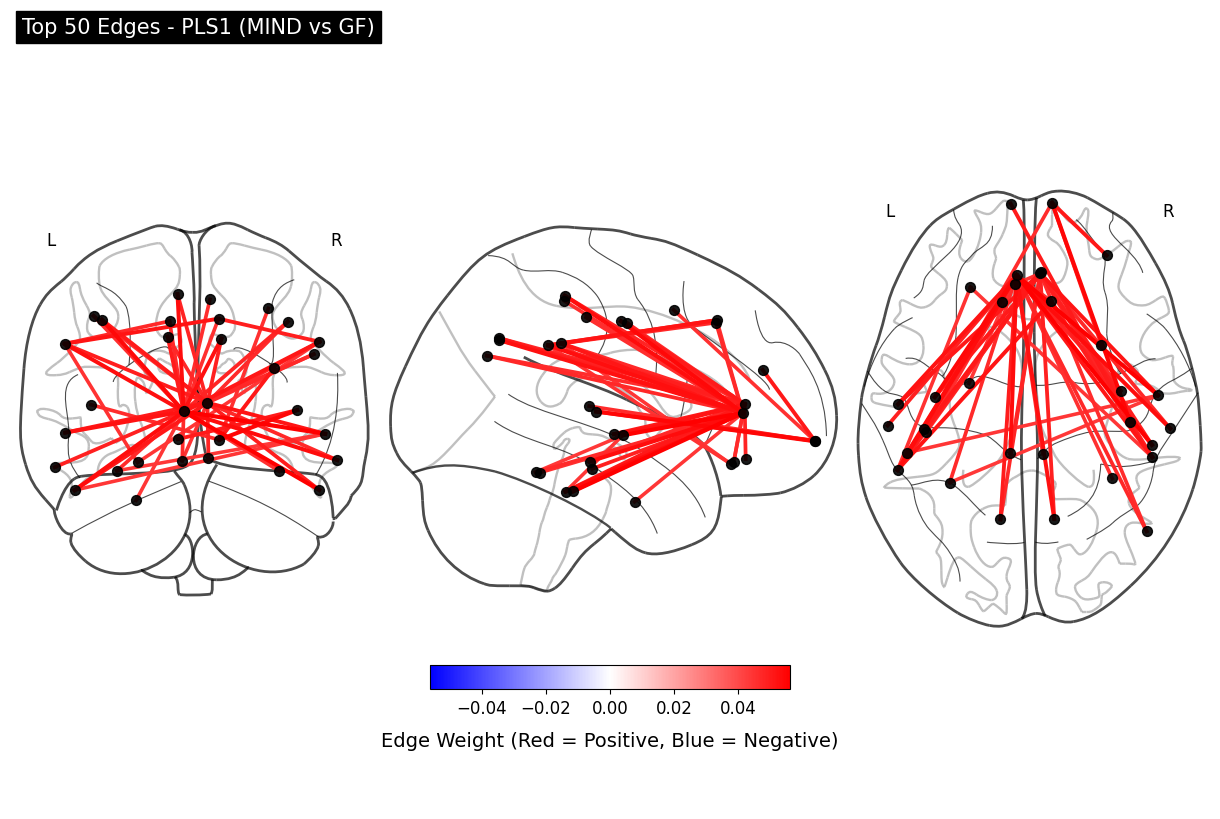

PLS2: Top edge weight magnitude: 0.0688


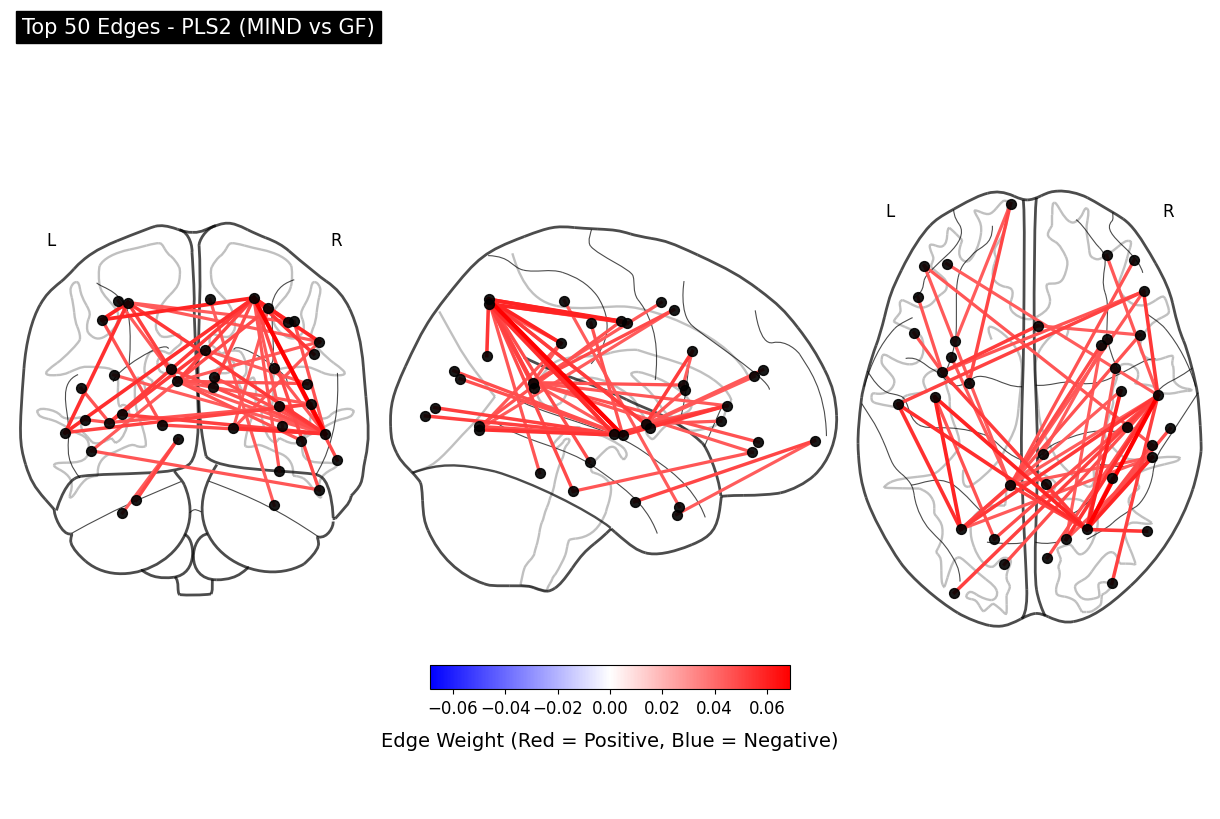

PLS3: Top edge weight magnitude: 0.0708


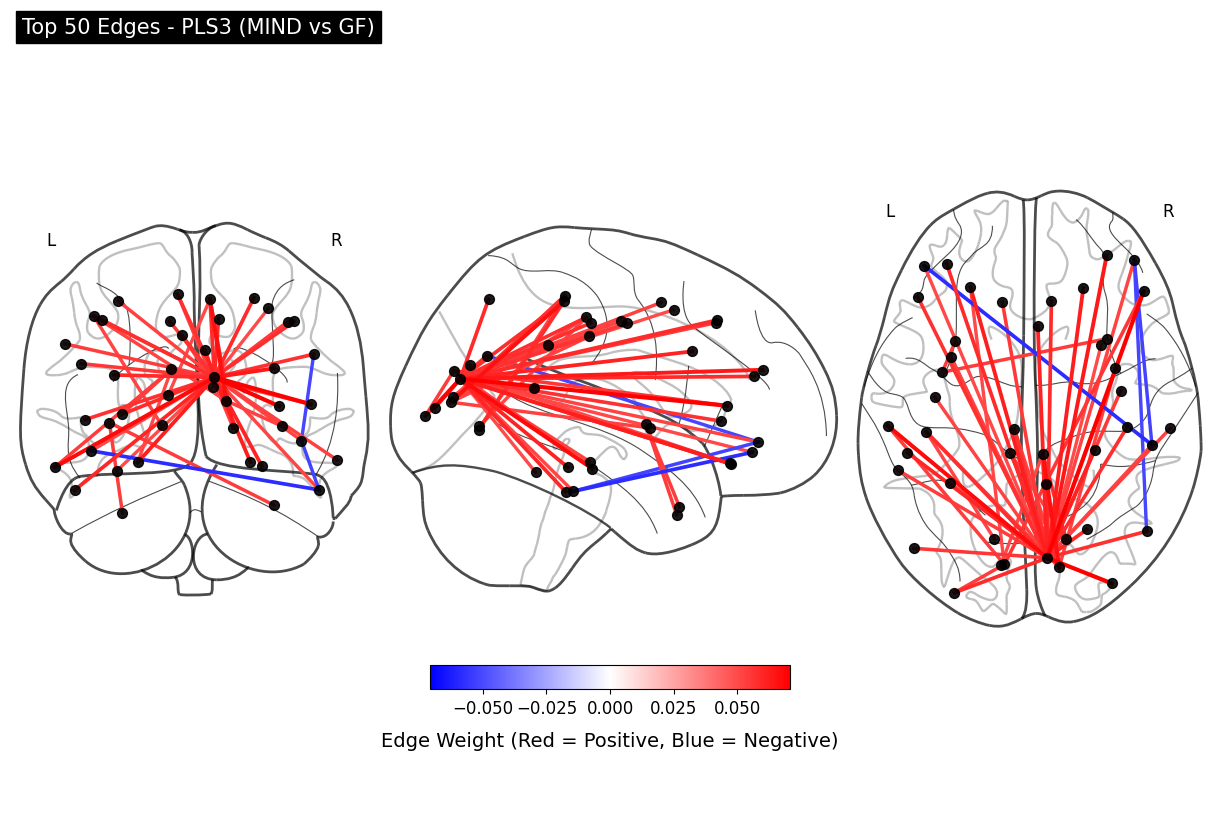

In [15]:
weights_file = '/Users/baileyng/MIND_models/models_plsregression/PLS_weights_reg/PLS_weights_MIND_GF5.csv'
plot_pls_weights(weights_file, 'MIND', 'GF', top_n=50)

# MATLAB reg

Loaded PLS weights from: /Users/baileyng/MIND_models/models_plsregression/PLS_weights_matlab/PLS_weights_MIND_GF5.csv
Shape: (2278, 5)
Components: ['Component_1', 'Component_2', 'Component_3', 'Component_4', 'Component_5']
PLS1: Top edge weight magnitude: 0.0000


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_82552/3703322127.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


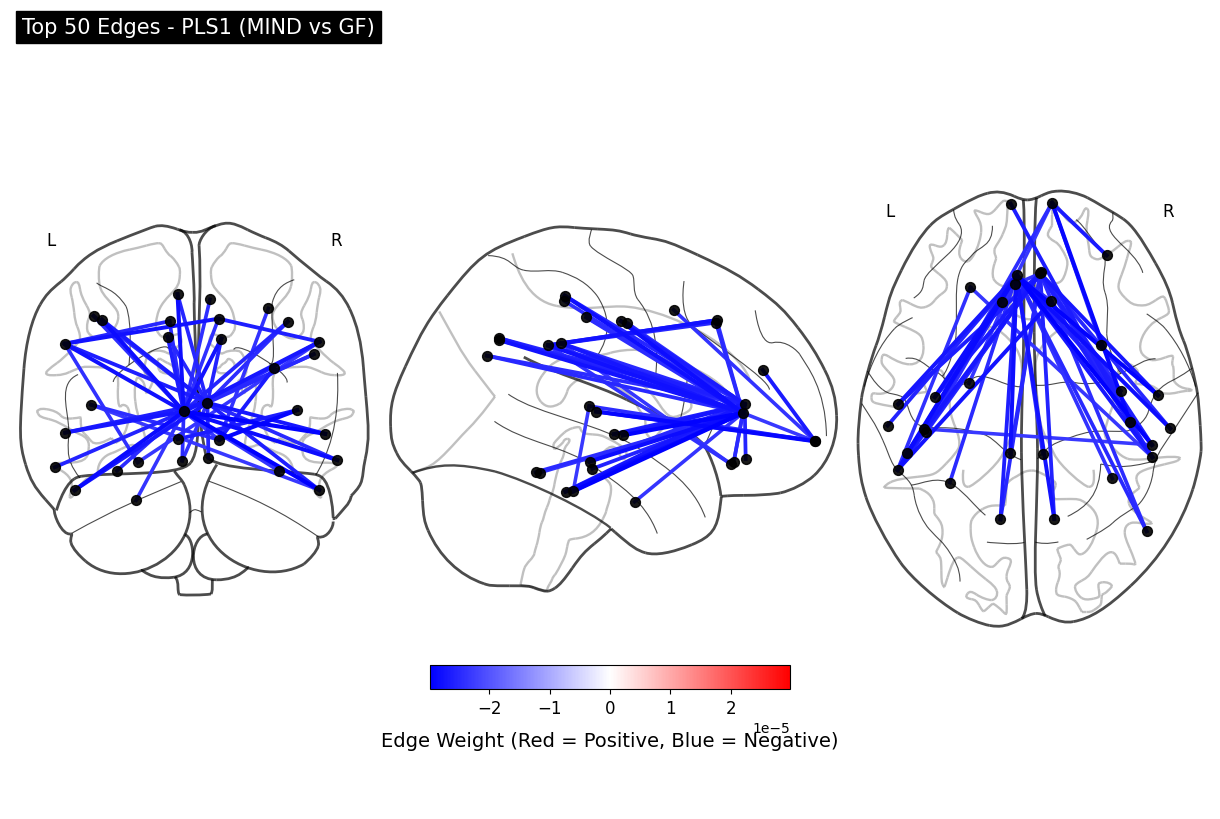

PLS2: Top edge weight magnitude: 0.0001


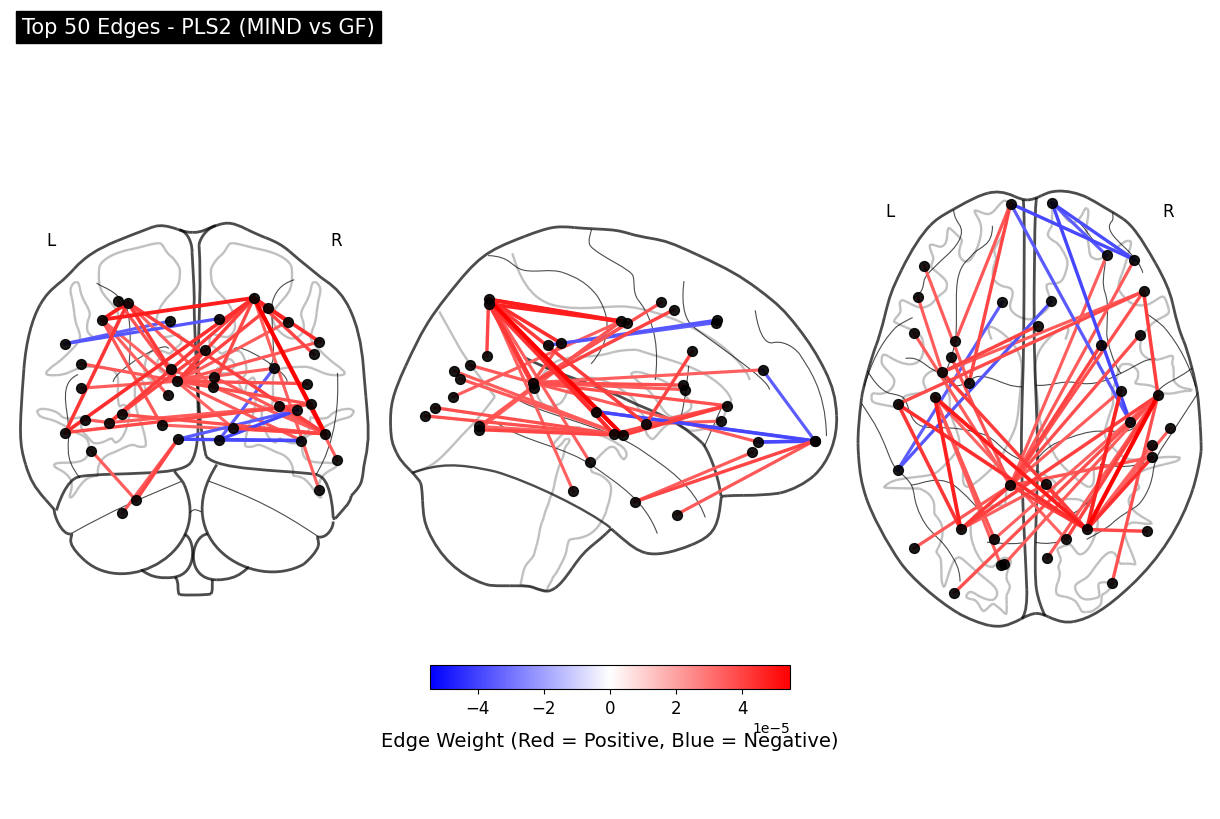

PLS3: Top edge weight magnitude: 0.0001


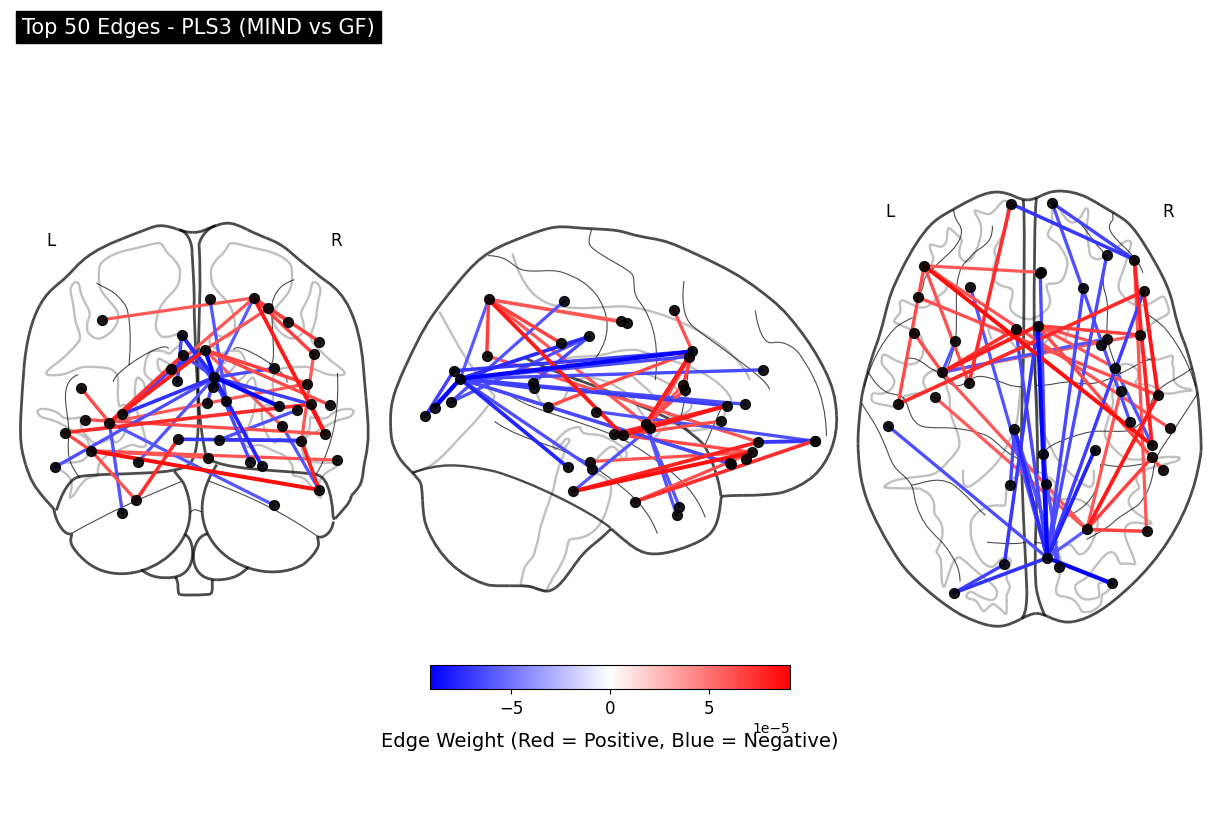

In [16]:
weights_file = '/Users/baileyng/MIND_models/models_plsregression/PLS_weights_matlab/PLS_weights_MIND_GF5.csv'
plot_pls_weights(weights_file, 'MIND', 'GF', top_n=50)